In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
#pip install pmdarima

In [3]:
#pip install mpl_interactions["jupyter"] 

In [4]:
spall = pd.read_csv('../data/sp500_cleaned-final.csv', low_memory=False,parse_dates=['Date'])
sp=spall

In [5]:
#Global variables
date_Filter = '2019-01-01'

In [6]:
sp

,Date,Open,High,Low,Close
0,1927-12-30,17.66,17.66,17.66,17.66
1,1928-01-03,17.76,17.76,17.76,17.76
2,1928-01-04,17.72,17.72,17.72,17.72
3,1928-01-05,17.55,17.55,17.55,17.55
4,1928-01-06,17.66,17.66,17.66,17.66
...,...,...,...,...,...
23953,2023-05-12,4138.54,4143.74,4099.12,4124.08
23954,2023-05-15,4126.65,4141.25,4110.27,4136.28
23955,2023-05-16,4127.95,4135.54,4109.86,4109.90
23956,2023-05-17,4122.85,4164.67,4113.62,4158.77


# Functions used

In [7]:
#MAPE - will be used to measure the performance of the model
#https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python
#The lower the MAPE value, the better the forecasting model performance.

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
#Create dataframe from test and Pred
def getTestPredDF(test_df, pred_df):
    cols = ['date', 'y_test', 'y_pred']
    res_df=pd.DataFrame(data=[test_df.index.to_numpy(),test_df["Close"].to_numpy(), pred_df]).T
    res_df.columns = cols
    return res_df    

In [9]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
                    # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse 
            })

In [10]:
# SP500
#Filter the SP data 
sp = sp[sp['Date'] > date_Filter]
sp = sp.drop(['Open','High','Low'], axis=1).sort_values(by='Date',ascending=True) 
# Scale Close price
#sp[['Close']] = scaler.fit_transform(sp[['Close']])
print(sp)


            Date    Close
22855 2019-01-02  2510.03
22856 2019-01-03  2447.89
22857 2019-01-04  2531.94
22858 2019-01-07  2549.69
22859 2019-01-08  2574.41
...          ...      ...
23953 2023-05-12  4124.08
23954 2023-05-15  4136.28
23955 2023-05-16  4109.90
23956 2023-05-17  4158.77
23957 2023-05-18  4198.05

[1103 rows x 2 columns]


In [11]:
sp.index = sp.pop('Date')
sp

,Close
Date,
2019-01-02,2510.03
2019-01-03,2447.89
2019-01-04,2531.94
2019-01-07,2549.69
2019-01-08,2574.41
...,...
2023-05-12,4124.08
2023-05-15,4136.28
2023-05-16,4109.90


In [12]:
df=sp
df

,Close
Date,
2019-01-02,2510.03
2019-01-03,2447.89
2019-01-04,2531.94
2019-01-07,2549.69
2019-01-08,2574.41
...,...
2023-05-12,4124.08
2023-05-15,4136.28
2023-05-16,4109.90


### S&P 500 Price till May 2023

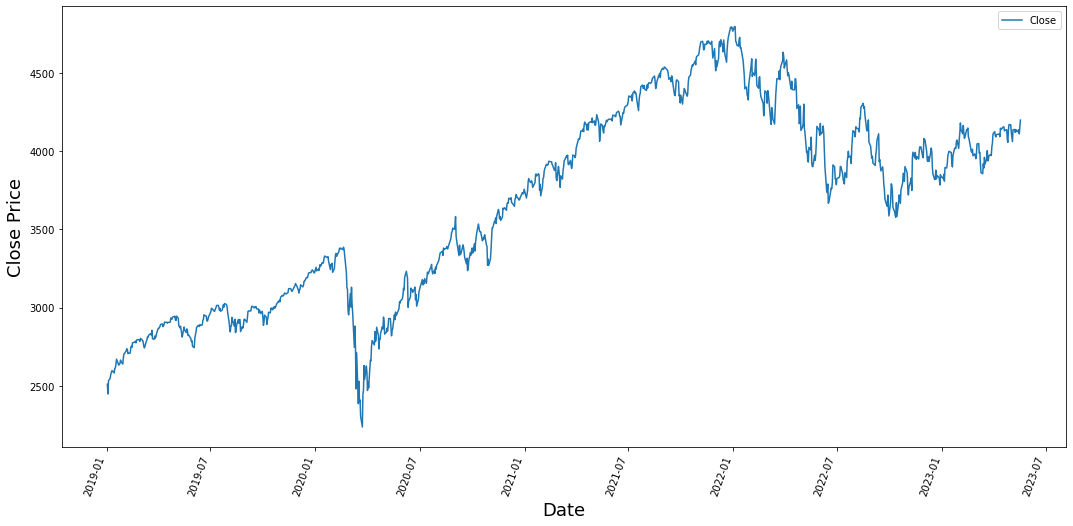

In [13]:
#Plot sp500
sp.plot.line(y="Close", use_index=True, figsize = (18,9))
plt.xticks(rotation=70)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()


# ARIMA
short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.




An ARIMA model is characterized by 3 terms: p, d, q where,

p is the order of the AR term 

q is the order of the MA term

d is the number of differencing required to make the time series stationary

## Components of a Time Series:
### Trend:
The trend shows a general direction of the time series data over a long period of time. A trend can be increasing(upward), decreasing(downward), or horizontal(stationary).
### Seasonality:
The seasonality component exhibits a trend that repeats with respect to timing, direction, and magnitude. Some examples include an increase in water consumption in summer due to hot weather conditions, or an increase in the number of airline passengers during holidays each year.
### Cyclical Component: 
These are the trends with no set repetition over a particular period of time. A cycle refers to the period of ups and downs, booms and slums of a time series, mostly observed in business cycles. These cycles do not exhibit a seasonal variation but generally occur over a time period of 3 to 12 years depending on the nature of the time series.
### Irregular Variation: 
These are the fluctuations in the time series data which become evident when trend and cyclical variations are removed. These variations are unpredictable, erratic, and may or may not be random.
### ETS Decomposition
ETS Decomposition is used to separate different components of a time series. The term ETS stands for Error, Trend, and Seasonality.

### Stationarity check of S&P 500


In [14]:
#Seasonal component
#The seasonal component explains the periodic ups and downs 

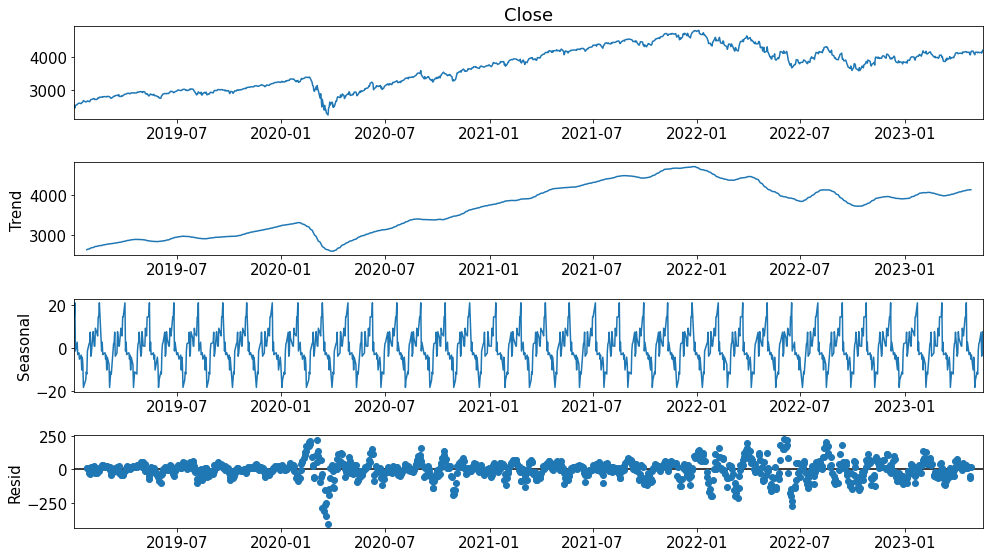

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(sp.Close,model='additive', period=30)
fig = result.plot()


### Points:

Monthly seasonal pattern is visible
An upwards,downwards, and sideways trend is evident

### Augmented Dickey Fuller (ADFuller) Test

In [17]:
#Lets perform ADFuller test to check if the series is stationary
from statsmodels.tsa.stattools import adfuller

def adfuller_test(dataset):
  adfresult = adfuller(dataset, autolag = 'AIC')
  print("1. ADF Statistic: ",adfresult[0])
  print("2. p-value : ", adfresult[1])
  print("3. Num Of Lags : ", adfresult[2])
  print("4. Num Of Observations :", adfresult[3])
  print("5. Critical Values :")
  for key, val in adfresult[4].items():
      print("\t",key, ": ", val)

In [18]:
adfuller_test(df['Close'])

1. ADF Statistic:  -1.6369014959425516
2. p-value :  0.4638803057763014
3. Num Of Lags :  10
4. Num Of Observations : 1092
5. Critical Values :
	 1% :  -3.436352507699052
	 5% :  -2.86419037625175
	 10% :  -2.56818114683546


#### The output above shows that the p-value is greater than the significance level of 0.05, so we fail to reject the null hypothesis. The series is not stationary and requires differencing.
let’s difference the series and see how the autocorrelation plot looks like.

In [19]:
diff_1 = df['Close'].diff().dropna()
print("p-value:", adfuller(diff_1.dropna())[1])

p-value: 7.457834290526893e-18


### The p-value is now below the significance level, indicating that the series is stationary.

In [ ]:
# import numpy as np, pandas as pd
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# spadf = spall[spall['Date'] > '2020-01-01']
# spadf = spadf.drop(['Open','High','Low'], axis=1).sort_values(by='Date',ascending=True) 
# spadf.index = spadf.pop('Date')

# # scaler_spadf = MinMaxScaler()
# # spadf[['Close']] = scaler_spadf.fit_transform(spadf[['Close']])
# print(spadf)

# # Original Series
# fig, axes = plt.subplots(3, 2, sharex=True)
# axes[0, 0].plot(spadf['Close']); axes[0, 0].set_title('Original Series')
# plot_acf(spadf['Close'], ax=axes[0, 1],lags=30)

# # 1st Differencing
# axes[1, 0].plot(spadf.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
# plot_acf(spadf['Close'].diff().dropna(), ax=axes[1, 1],lags=30)

# # 2nd Differencing
# axes[2, 0].plot(spadf.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
# plot_acf(spadf['Close'].diff().diff().dropna(), ax=axes[2, 1],lags=30)

# plt.show()

In [20]:
spadf

NameError: name 'spadf' is not defined

## ACF and PACF plots

####  The autocorrelation function will show the relationship between a point in time and lagged values

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


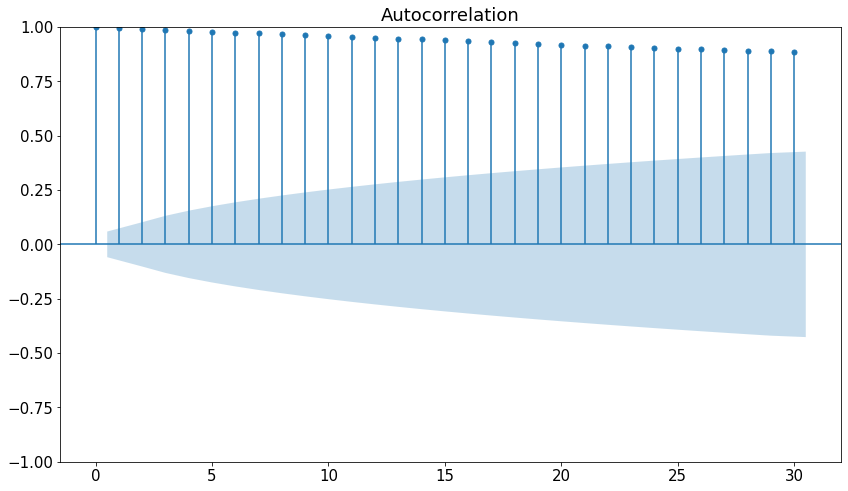

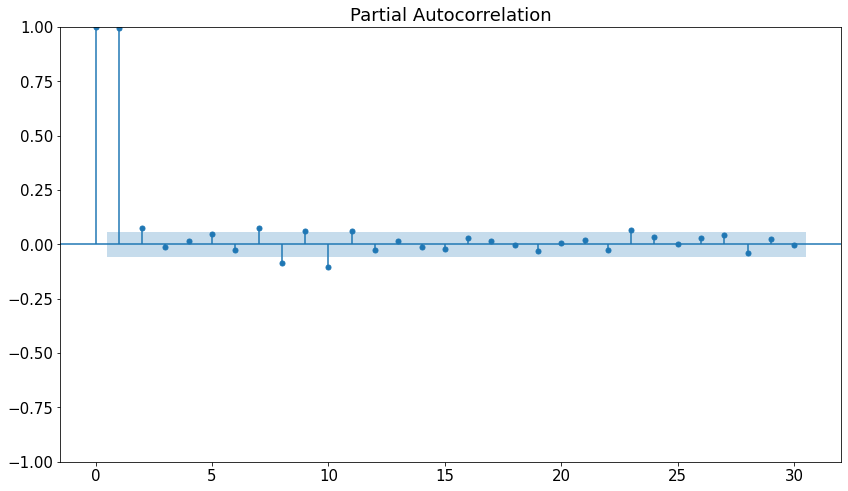

In [24]:
#Original Series
plot_acf(sp['Close'], lags=30);
plot_pacf(sp['Close'], lags=30);

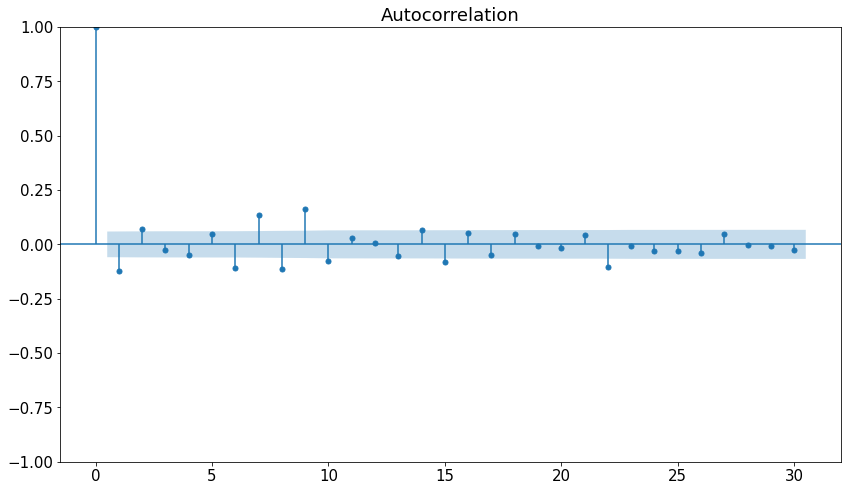

In [22]:
# 1st Differencing
plot_acf(sp['Close'].diff().dropna(), lags=30);

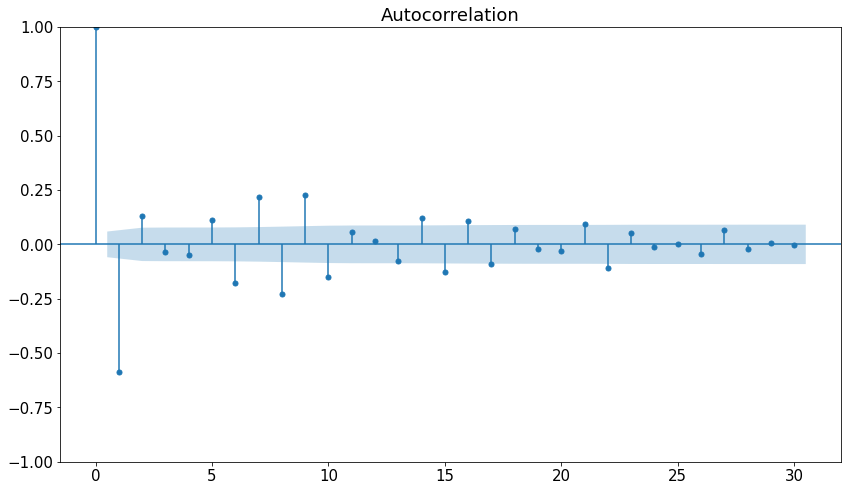

In [25]:
# 2nd Differencing
plot_acf(sp['Close'].diff().diff().dropna(), lags=30);

# Estimating AR term(p)

#### In plot above, we see that ACF and PACF results. To estimate the amount of AR terms, we need to look at the PACF plot. First, ignore the value at lag 0. It will always show a perfect correlation, since we are estimating the correlation between today’s value with itself. The blue area in the plot, represents the confidence interval. To estimate how much AR terms we should use, we start counting how many “Pins” are above or below the confidence interval before the next one enter the blue area.

#### So, looking at the PACF(fig 2) plot above, we can estimate to use 2 AR terms for our model, since lag 1 and 2 are out of the confidence interval, and lag 3 is in the blue area.

#  Estimate I(d) term, the order of differencing 
Estimate the amount of I (d) terms is to know how many Differencing was used to make the series stationary. 
For example, if we used log difference or first difference to transform a time series, the amount of I terms will be 1.
Since we diffrentiated 2 times the d=2

# Estimating MA(q) terms
Just like the PACF function, to estimate the amount of MA terms, this time we will look at ACF plot. The same logic is applied here: how much Pins are above or below the confidence interval before the next lollipop enters the blue area?

In our example, we can estimate 80 MA terms, since we have lag prior to 80 out of the confidence interval.

In [26]:
p=3
d=2
q=62

In [28]:
#Split Train and Test data
print(df.shape)
train=df.iloc[:-110]
test=df.iloc[-110:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1103, 1)
(993, 1) (110, 1)
Close    3934.38
Name: 2022-12-09 00:00:00, dtype: float64 Close    4198.05
Name: 2023-05-18 00:00:00, dtype: float64


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model_res1=ARIMA(train['Close'],order=(3,2,62))
model=model_res1.fit()
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
#find d

from pmdarima.arima.utils import ndiffs

y = spadf.Close

## Adf Test
adf=ndiffs(y, test='adf')  # 2

# KPSS test
kpss=ndiffs(y, test='kpss')  # 0

# PP test:
pp= ndiffs(y, test='pp')  # 2
print(adf)
print(kpss)
print(pp)

In [ ]:
# # PACF plot of 1st differenced series
# plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# fig, axes = plt.subplots(1, 2, sharex=True)
# axes[0].plot(df.Close.diff()); axes[0].set_title('1st Differencing')
# axes[1].set(ylim=(0,5))
# plot_pacf(df.Close.diff().dropna(), ax=axes[1], lags=40)

# plt.show()

### Auto Arima to get parameters

In [ ]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
stepwise_fit = auto_arima(df['Close'],trace=True, 
                          suppress_warnings=True)           

stepwise_fit.summary()

# Model-1: Auto ARIMA

In [ ]:
model_ar_auto=ARIMA(train['Close'],order=(2,1,2))
model_ar_auto=model_ar_auto.fit()
model_ar_auto.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred_ar_auto=model_ar_auto.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')

In [ ]:
pred_ar_auto

In [ ]:
df_auto = getTestPredDF(test, pred_ar_auto)
df_auto

In [ ]:
df_auto.tail(20)

In [ ]:
#Plot Test VS predicted
plt.figure(figsize=(18,10))
plt.plot(df_auto['date'].to_numpy() , df_auto['y_test'].to_numpy(), label="original" )
plt.plot(df_auto['date'].to_numpy() , df_auto['y_pred'].to_numpy(), label="predicted" )
plt.legend()
plt.show()

Above we see that the predicted values are pretty much flat.

# Get Hyper parameters p, d, q for ARIMA

In [ ]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
p = range(0,8)
d = range(0,2)
q = range(0,8)

rmse=[]
order=[]
pdq_combination = (list(itertools.product(p,d,q)))
start=len(train)
end=len(train)+len(test)-1

for pdq in pdq_combination:
    try:
        model=ARIMA(train['Close'],order=(pdq))
        model=model.fit()
        s=model.summary() 
        pred=model.predict(start=len(train),end=end)
        error=np.sqrt(mean_squared_error(test,pred))
        order.append(pdq)
        rmse.append(error)

    except Exception as e:
        print(e)
    finally:
        print('pdq: ')
        print(pdq)        
        print('error: ')
        print(error)

In [ ]:
cols = ['pdq', 'rmse']
results=pd.DataFrame(data=[order,rmse]).T
results.columns=cols
results
results.to_csv('ARIMA_results.csv')

In [ ]:
#from the csv best parameters, for least MSE are
#105	(6, 1, 1)	116.8841655


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model_ar_manual=ARIMA(train['Close'],order=(6,1,1))
model_ar_manual=model_ar_manual.fit()
model_ar_manual.summary()


In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred_ar_manual=model_ar_manual.predict(start=start,end=end,typ='levels').rename('ARIMA predictions for Manual Fit Model')

In [ ]:
df_manual = getTestPredDF(test, pred_ar_manual)
df_manual

In [ ]:
#Plot Test VS predicted
plt.figure(figsize=(18,10))
plt.plot(df_manual['date'].to_numpy() , df_manual['y_test'].to_numpy(), label="original" )
plt.plot(df_manual['date'].to_numpy() , df_manual['y_pred'].to_numpy(), label="predicted" )
plt.legend()
plt.show()

In [ ]:
forecast_accuracy( df_manual['y_pred'].to_numpy(), df_manual['y_test'].to_numpy())

In [ ]:
test['Close'].mean()

In [ ]:
model2_res=ARIMA(df['Close'],order=(1,0,3))
model2=model2_res.fit()
df.tail()

In [ ]:
model2.summary()

In [ ]:

pred2=model2.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred2

In [ ]:
def getTestPredDF(test_df, pred_df):
    cols = ['date', 'y_test', 'y_pred']
    res_df=pd.DataFrame(data=[test_df.index.to_numpy(),test_df["Close"].to_numpy(), pred_df]).T
    res_df.columns = cols
    res_df    
   

In [ ]:
sp_res2= getTestPredDF(test, pred2)

In [ ]:
#Plot Test VS predicted
plt.figure(figsize=(18,10))
plt.plot(sp_res2['date'].to_numpy() , sp_res2['y_test'].to_numpy(), label="original" )
plt.plot(sp_res2['date'].to_numpy() , sp_res2['y_pred'].to_numpy(), label="predicted" )
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(model2, start="2023-05-12", end="2023-05-18", ax=ax)
legend = ax.legend(loc="upper left")

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test.Close, pred2)

In [ ]:
forecast_accuracy( sp_res2['y_pred'].to_numpy(), sp_res2['y_test'].to_numpy())

In [ ]:
pred2

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model2.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

#### residual errors seem fine with near zero mean and uniform variance

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict
res = ARIMA(sp, order=(1,0,3)).fit()
fig, ax = plt.subplots()
ax = sp.loc['1990':].plot(ax=ax)
plot_predict(res, '2021', '2023', ax=ax)
plt.show()



In [ ]:
sp

In [ ]:
#Predict future prices
index_future_dates=pd.date_range(start='2023-05-20',end='2023-06-19')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

In [ ]:
type(pred)

In [ ]:
dfFut = pred.to_frame(name='pred_future')
dfFut.reset_index(inplace=True)
dfFut.rename(columns={'index':'date'}, inplace=True)

dfFut

In [ ]:
#Plot Test VS predicted
plt.figure(figsize=(18,10))
plt.plot(sp_res2['date'].to_numpy() , sp_res2['y_test'].to_numpy(), label="original" )
plt.plot(sp_res2['date'].to_numpy() , sp_res2['y_pred'].to_numpy(), label="predicted" )
plt.plot(dfFut['date'].to_numpy() , dfFut['pred_future'].to_numpy(), label="predicted future" )
plt.legend()
plt.show()

# Model 3: 6,1,1
105	(6, 1, 1)	116.8841655


In [ ]:
model3_res=ARIMA(df['Close'],order=(6,1,1))
model3_res=model3_res.fit()
model3_res.summary()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


model3_611_arima=ARIMA(df['Close'],order=(6,1,1))
model3_611=model3_611_arima.fit()
model3_611.summary()

# Forecast
#fc, se, conf = model3.forecast(5, alpha=0.05)  # 95% conf

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred3=model3_611.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred3

In [ ]:
# creating a list of column names
cols3 = ['date', 'y_test', 'y_pred']
sp_res3=pd.DataFrame(data=[test.index.to_numpy(),test["Close"].to_numpy(), pred3]).T
sp_res3.columns = cols3
sp_res3

### Forecast using ARIMA model3_611

In [ ]:
index_future_dates_3=pd.date_range(start='2023-05-20',end='2023-06-19')
pred3_fut=model3_611.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred3_fut.index=index_future_dates_3
#print(pred3_fut)

dfFut_3 = pred3_fut.to_frame(name='pred_future')
dfFut_3.reset_index(inplace=True)
dfFut_3.rename(columns={'index':'date'}, inplace=True)

dfFut_3


In [ ]:
#Plot Test VS predicted
plt.figure(figsize=(18,10))
plt.plot(sp_res3['date'].to_numpy() , sp_res3['y_test'].to_numpy(), label="original" )
plt.plot(sp_res3['date'].to_numpy() , sp_res3['y_pred'].to_numpy(), label="predicted" )
plt.plot(dfFut_3['date'].to_numpy() , dfFut_3['pred_future'].to_numpy(), label="predicted future" )
plt.legend()
plt.show()

In [ ]:
test

In [ ]:

# Build Model
model = ARIMA(train, order=(2, 2, 1))  
fitted = model.fit()  
print(fitted.summary())


In [ ]:
forecast_accuracy( sp_res2['y_pred'].to_numpy(), sp_res2['y_test'].to_numpy())

In [ ]:
pred.plot(figsize=(12,5),legend=True)


In [ ]:
df